In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Taps\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Taps\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
strategyTable = pd.DataFrame(columns = ['ticker', 'strategy', 'annual_return', 'annual_vol', 'annual_sharpe',
                                        'cum_return', 'maxDD'])

# Data Import

In [3]:
class simpleProcessor():
    
    def __init__(self, priceFile, newsFile, tickerName, priceType):
        self.tickerName = tickerName
        self.priceType = priceType
        self.news_data = pd.read_csv(newsFile, index_col = [0])
        self.price_vol = pd.read_csv(priceFile, index_col= [0])
        self.crypto_price = self.price_vol[[tickerName + '-' + priceType]].shift(1)
        self.crypto_news = self.news_data[[tickerName]]
        self.crypto_price.index = pd.to_datetime(self.crypto_price.index).tz_convert(None)
        self.crypto_news.index = pd.to_datetime(self.crypto_news.index)
        self.data = None
        
    def getData(self):
        data = self.crypto_news.merge(self.crypto_price, how = 'inner', left_index = True, right_index = True)
        data[self.tickerName + '_summary'] = data.apply(lambda x :self.joinStr(x), axis = 1)
        data['returns'] = data[self.tickerName + '-' + self.priceType].pct_change().shift(-1)
        data['class'] = data['returns'] > 0
        data = data.iloc[:-1, :]
        
        nonewsdate = data[data.isna().any(axis = 1)].index
        newsdate = data[~data.isna().any(axis = 1)].index
        
        self.data = data[~data.isna().any(axis = 1)][[self.tickerName + '_summary', 'class']]
        self.data.columns = ['text', 'class']
        self.data['class'] = self.data['class'].map({True : 'positive', False : 'negative'})
        
        return self.data.copy(), data
        
    @staticmethod
    def joinStr(df):
        lists = eval(df[0])
        if(lists[0]):
            return ' '.join(lists[0])
        return np.nan

# Data Processing

In [4]:
def dataProcess(df):
    processed_data = []
    for text, cls in zip(df['text'], df['class']):
        doc = re.sub('[^A-Za-z]', ' ', text) # Remove non alphabetic characters
        doc = word_tokenize(doc.lower()) # Transform to lower case and word tokenization
        doc = [w for w in doc if w not in stopwords.words('english') ] # Remove stop words in English
        stemmer = PorterStemmer() # Stemming words
        doc = [stemmer.stem(w) for w in doc] # Stemming words
        doc_string = " ".join(doc) # Create string for CountVectorizer use in the future
        processed_data.append(doc_string)
        
    df['text'] = processed_data    

In [5]:
ticker = 'BNB'
train_data1, data = simpleProcessor('price_vol.csv', 'usdt_usdc_bnb.csv', ticker, 'close').getData()

In [180]:
dataProcess(train_data1)

In [181]:
n = train_data1.shape[0]
percent = 0.8
X_train, X_test = train_data1.iloc[0 : int(n*percent), 0], train_data1.iloc[int(n*percent):, 0]
y_train, y_test = train_data1.iloc[0 : int(n*percent), 1], train_data1.iloc[int(n*percent):, 1]

In [182]:
backtest = train_data1.iloc[int(n*percent):, :]

# Model

In [183]:
# Limit the features to 500 so we only use the most frequent 500 words
pipeline = Pipeline([('CountVectorizer', CountVectorizer(max_features=10000)), 
                     ('MNB', MultinomialNB())])

In [184]:
pipeline.fit(X_train, y_train)
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

## Train Data

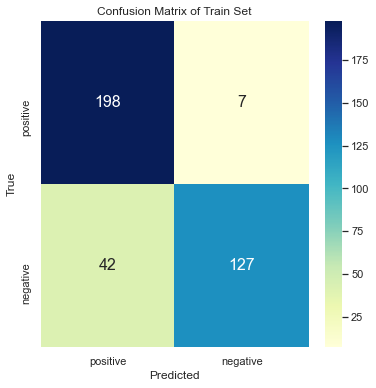

In [185]:
cm_train = confusion_matrix(y_train, y_pred_train, labels=['positive', 'negative'])
plt.figure(figsize = (6,6))
s = sns.heatmap(cm_train, annot= True, fmt = 'd', annot_kws={'size': 16}, 
                cmap ='YlGnBu', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
_ = s.set_xlabel('Predicted')
_ = s.set_ylabel('True')
_ = s.set_title('Confusion Matrix of Train Set')

In [186]:
print(classification_report(y_train, y_pred_train, labels = ['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.82      0.97      0.89       205
    negative       0.95      0.75      0.84       169

    accuracy                           0.87       374
   macro avg       0.89      0.86      0.86       374
weighted avg       0.88      0.87      0.87       374



## Test Data

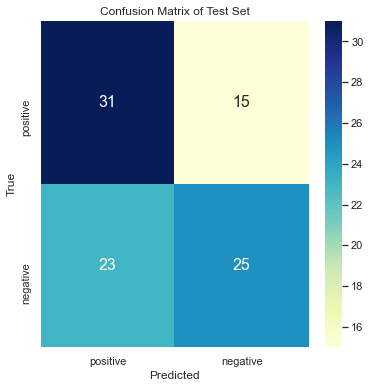

In [187]:
cm_test = confusion_matrix(y_test, y_pred_test, labels = ['positive', 'negative'])
plt.figure(figsize = (6,6))
s = sns.heatmap(cm_test, annot= True, fmt = 'd', annot_kws={'size': 16}, 
                cmap ='YlGnBu', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
_ = s.set_xlabel('Predicted')
_ = s.set_ylabel('True')
_ = s.set_title('Confusion Matrix of Test Set')

In [188]:
print(classification_report(y_test, y_pred_test, labels = ['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.57      0.67      0.62        46
    negative       0.62      0.52      0.57        48

    accuracy                           0.60        94
   macro avg       0.60      0.60      0.59        94
weighted avg       0.60      0.60      0.59        94



# Simple Backtest
May exist slight looking-ahead bias

In [189]:
class backtestMetrics:
    
    def __init__(self, df):
        self.df = df
        self.df_dailyreturn = (df - df.shift(1))/df.shift(1)
        self.N = len(df) - 1
        
    def get_return(self):
        return (np.power(self.df.iloc[-1,:]/self.df.iloc[0,:],365*24/self.N) - 1)[0]
    
    def get_vol(self):
        return (np.std(self.df_dailyreturn)*np.sqrt(365*24))[0]
    
    def get_sharpe(self):
        return (self.get_return()/self.get_vol())
    
    def get_cumReturn(self):
        return (self.df.iloc[-1,:]/self.df.iloc[0,:] - 1)[0]
    
    def get_maxdd(self):
        return ((np.maximum.accumulate(self.df) - self.df)/np.maximum.accumulate(self.df)).max()[0]
    
    def strategy_map(self, ticker, strategy_type):
        map1 = {'ticker': ticker,
        'strategy': strategy_type, 
        'annual_return': self.get_return(),
        'annual_vol': self.get_vol(),
        'annual_sharpe': self.get_sharpe(),
        'cum_return': self.get_cumReturn(),
        'maxDD': self.get_maxdd()}
        
        return map1

In [190]:
def simpleBacktest(backtest, y_pred_test, data):
    
    backtest['signal'] = y_pred_test
    backtest_start_date = backtest.index[0]
    
    allBacktest = data[data.index >= backtest_start_date][['returns']]
    backtestTable = allBacktest.merge(backtest[['signal']], how = 'left', left_index=True, right_index=True)
    backtestTable = backtestTable.fillna(method = 'ffill') # maintain viewpoints
    
    def simpleBacktest(df):
        if(df[1] == 'positive'):
            return df[0]
        return 0.0
    
    backtestTable['realized_returns'] = backtestTable.apply(lambda x: simpleBacktest(x), axis = 1)
    backtestTable['strat_nav'] = (1 + backtestTable['realized_returns']).cumprod()
    backtestTable['nav'] = (1 + backtestTable['returns']).cumprod()
    
    return backtestTable

In [191]:
backtestTable = simpleBacktest(backtest, y_pred_test, data)

C:\Users\Taps\AppData\Local\Temp\ipykernel_22696\3886734011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest['signal'] = y_pred_test


In [192]:
backtestTable.to_csv("backtest_{}.csv".format(ticker))

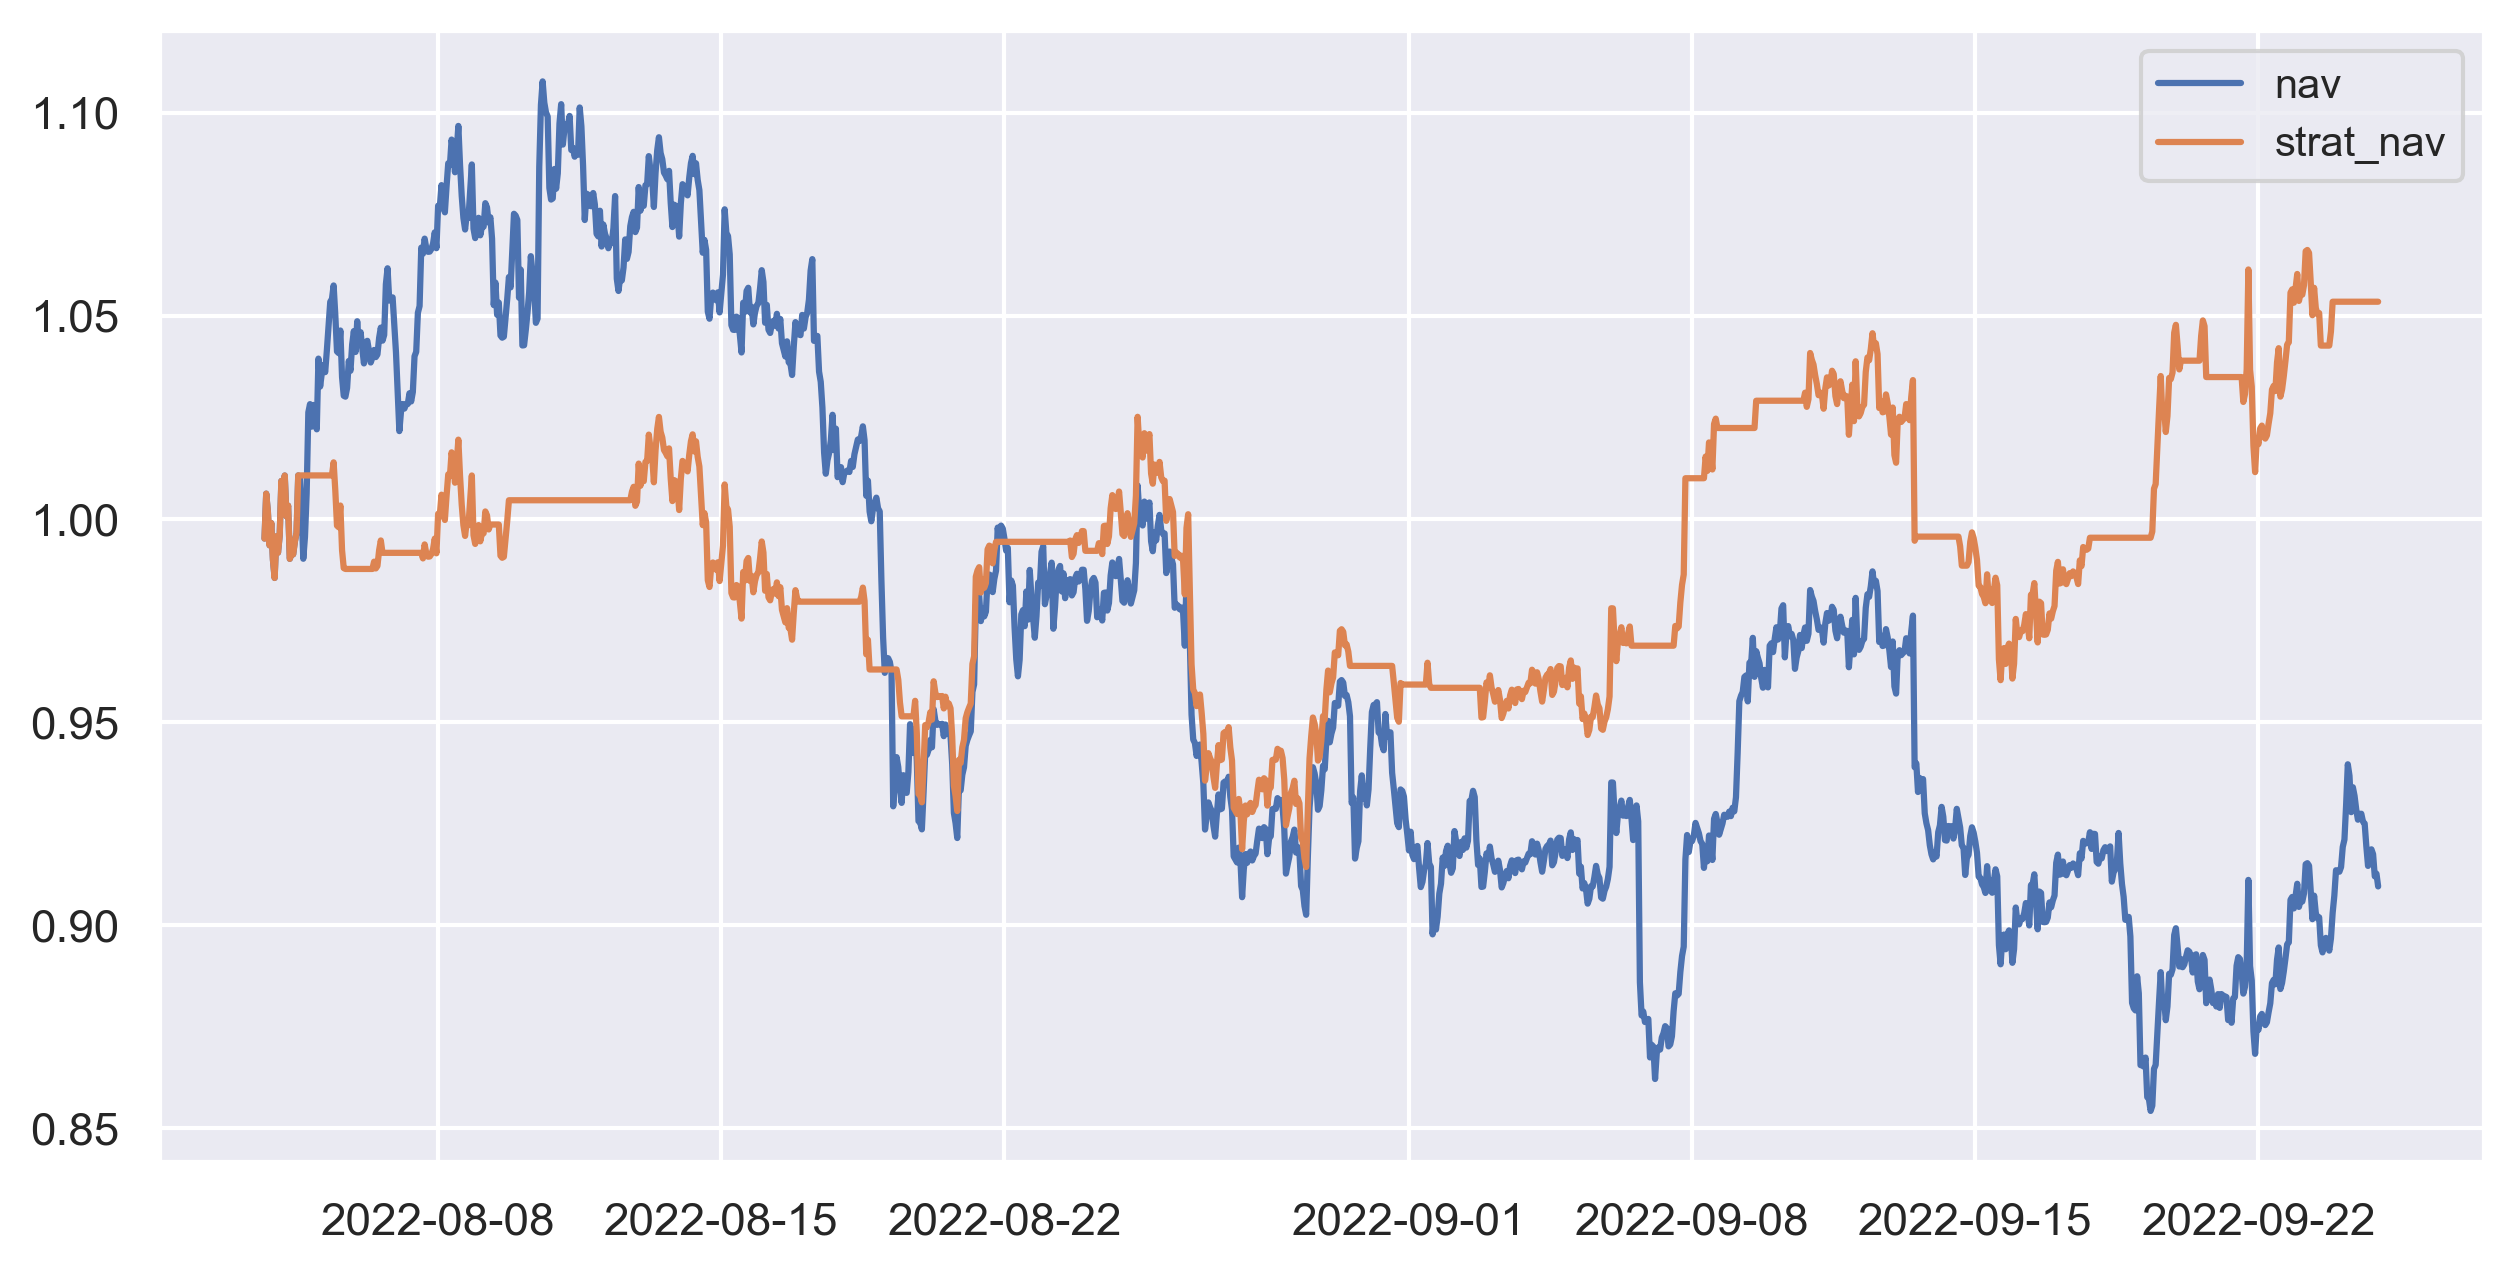

In [193]:
sns.set()
plt.figure(figsize=(10, 5), dpi = 300)
plt.plot(backtestTable['nav'], label='nav')
plt.plot(backtestTable['strat_nav'], label='strat_nav')
plt.legend(fontsize=10)

In [194]:
print("Simple Strategy")
strategyMetrics = backtestMetrics(backtestTable[['strat_nav']])
print("Annual Return : {}".format(strategyMetrics.get_return()))
print("Annual Vol : {}".format(strategyMetrics.get_vol()))
print("Annual Sharpe : {}".format(strategyMetrics.get_sharpe()))
print("Cumulative Return : {}".format(strategyMetrics.get_cumReturn()))
print("Annual Max DD : {}".format(strategyMetrics.get_maxdd()))

Simple Strategy
Annual Return : 0.4886296013556002
Annual Vol : 0.39191919066530634
Annual Sharpe : 1.2467611002312036
Cumulative Return : 0.058606429544385774
Annual Max DD : 0.10814268606716472


In [195]:
strategyTable = strategyTable.append(backtestMetrics(backtestTable[['strat_nav']]).strategy_map(ticker, 'simple_strategy'), ignore_index=True)

In [196]:
print("Buy and Hold")
strategyMetrics = backtestMetrics(backtestTable[['nav']])
print("Annual Return : {}".format(strategyMetrics.get_return()))
print("Annual Vol : {}".format(strategyMetrics.get_vol()))
print("Annual Sharpe : {}".format(strategyMetrics.get_sharpe()))
print("Cumulative Return : {}".format(strategyMetrics.get_cumReturn()))
print("Annual Max DD : {}".format(strategyMetrics.get_maxdd()))

Buy and Hold
Annual Return : -0.4667574473653573
Annual Vol : 0.5551094869890442
Annual Sharpe : -0.8408385342089629
Cumulative Return : -0.08607807138606072
Annual Max DD : 0.22886624599810218


In [197]:
strategyTable = strategyTable.append(backtestMetrics(backtestTable[['nav']]).strategy_map(ticker, 'buy_and_hold'), ignore_index=True)

In [198]:
strategyTable

,ticker,strategy,annual_return,annual_vol,annual_sharpe,cum_return,maxDD
0,BTC,simple_strategy,-0.573436,0.402748,-1.423809,-0.094883,0.148486
1,BTC,buy_and_hold,-0.895990,0.526264,-1.702547,-0.232658,0.259941
2,ETH,simple_strategy,0.459119,0.525706,0.873339,0.042365,0.207787
3,ETH,buy_and_hold,-0.964619,0.781899,-1.233687,-0.307165,0.364040
4,BNB,simple_strategy,0.488630,0.391919,1.246761,0.058606,0.108143
5,BNB,buy_and_hold,-0.466757,0.555109,-0.840839,-0.086078,0.228866


In [199]:
strategyTable.to_csv("strategyTable.csv")